# Import Libraries

In [1]:
!pip install tweepy

     |████████████████████████████████| 76 kB 648 kB/s            
     |████████████████████████████████| 63 kB 849 kB/s            
     |████████████████████████████████| 151 kB 3.0 MB/s            
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
  Attempting uninstall: oauthlib
    Found existing installation: oauthlib 3.1.1
    Uninstalling oauthlib-3.1.1:
      Successfully uninstalled oauthlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
spacy 3.2.2 requires typing-extensions<4.0.0.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.1.1 which is incompati

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder

import tweepy

from warnings import filterwarnings
filterwarnings ('ignore')

<hr style="height:2px;border-width:0;color:white;background-color:green">

# Twitter API
<br>

##### For more informations about Twitter API you can use this link.
https://developer.twitter.com/en/docs/twitter-api

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

secret_value_0 = user_secrets.get_secret("access_token")
secret_value_1 = user_secrets.get_secret("access_token_secret")
secret_value_2 = user_secrets.get_secret("consumer_key")
secret_value_3 = user_secrets.get_secret("consumer_secret")

In [4]:
auth = tweepy.OAuthHandler(secret_value_2, secret_value_3)
auth.set_access_token(secret_value_0, secret_value_1)
api = tweepy.API(auth)

In [5]:
# We get the tweets with hastag "BTC", in english.

tweets = api.search_tweets(q = "BTC", lang = "en", count = 100)

In [6]:
def hashtag_df(tweets):
    import pandas as pd
    id_list = [tweet.id for tweet in tweets]
    dataframe = pd.DataFrame(id_list, columns = ["id"])
    
    dataframe["user"] = [tweet.author.screen_name for tweet in tweets]
    dataframe["text"] = [tweet.text for tweet in tweets]
    dataframe["hashtags"] = [tweet.entities.get("hashtags") for tweet in tweets]
    
    return dataframe

In [7]:
df = hashtag_df(tweets)
df = df.drop_duplicates("user", keep = "first")
df.drop("id", axis=1, inplace=True)
df.index = df["user"]
df.drop("user", axis=1, inplace=True)

# Let's see our dataset...

df.head()

,text,hashtags
user,,
Widiyan22384577,RT @crypto_smilez: #Dogecoin VS. #Apecoin | #G...,"[{'text': 'Dogecoin', 'indices': [19, 28]}, {'..."
TinFoilFTM,RT @Trobriand15: Vitalik Buterin has been inte...,[]
dblezzz,RT @wayki_chain: We made to the 90K!\n\nFollow...,"[{'text': 'BitcoinButton', 'indices': [83, 97]..."
AgeingTrex,on the 4H is looking pretty primed. Hold stead...,[]
barlylong,RT @altnftworld: 0.2 ETH ($550)💰\n\nNFT Giveaw...,"[{'text': 'NFT', 'indices': [127, 131]}]"


<hr style="height:2px;border-width:0;color:white;background-color:green">

# Dataset Cleaning

In [8]:
# Texts will be lower
df["text"] = df["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))

# We get rid of the punctuations
df["text"] = df["text"].str.replace('[^\w\s]', '')

# And also numbers we don't need it in text.
df["text"] = df["text"].str.replace('\d', '')

# Stopwords! It is a library with some adverbs, plural suffix etc. that they are not important for the analysis
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

# We reach to the root of the word with lemmatize.
from textblob import Word
nltk.download('wordnet')
df["text"] = df["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Retweets... We don't need them.
df["text"] = df["text"].str.replace('rt','')

# reset index
df = df.reset_index()
df.head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,user,text,hashtags
0,Widiyan22384577,crypto_smilez dogecoin v apecoin giveaway vot...,"[{'text': 'Dogecoin', 'indices': [19, 28]}, {'..."
1,TinFoilFTM,trobriand vitalik buterin interviewed time ht...,[]
2,dblezzz,wayki_chain made k follow win wicc lucky draw...,"[{'text': 'BitcoinButton', 'indices': [83, 97]..."
3,AgeingTrex,h looking pretty primed hold steady cvc httpst...,[]
4,barlylong,altnftworld eth nft giveaway enter follow alt...,"[{'text': 'NFT', 'indices': [127, 131]}]"


<hr style="height:2px;border-width:0;color:white;background-color:green">

# Sentiment Analysis

In [9]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 627 kB/s            


In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

# The range of polarity is from -1 to 1(negative to positive) and will tell us if the text contains positive or negative feedback.
df["polarity_score"] = df["text"].apply(lambda x: vader.polarity_scores(x)["compound"])

# So we labeling the scores as positive or negative.
df["sentiment_label"] = df["text"].apply(lambda x: "pos" if vader.polarity_scores(x)["compound"] > df["polarity_score"].median() else "neg")

# That part is just for encoding.
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

df.head()

,user,text,hashtags,polarity_score,sentiment_label
0,Widiyan22384577,crypto_smilez dogecoin v apecoin giveaway vot...,"[{'text': 'Dogecoin', 'indices': [19, 28]}, {'...",0.7269,1
1,TinFoilFTM,trobriand vitalik buterin interviewed time ht...,[],0.0000,0
2,dblezzz,wayki_chain made k follow win wicc lucky draw...,"[{'text': 'BitcoinButton', 'indices': [83, 97]...",0.7650,1
3,AgeingTrex,h looking pretty primed hold steady cvc httpst...,[],0.4939,1
4,barlylong,altnftworld eth nft giveaway enter follow alt...,"[{'text': 'NFT', 'indices': [127, 131]}]",0.6908,1


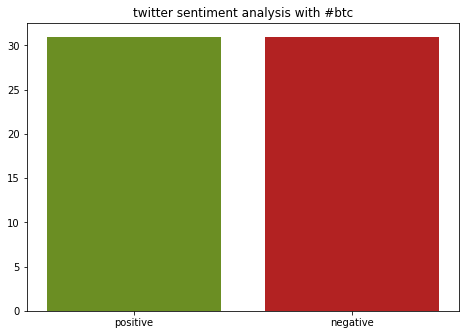

In [11]:
# Let's check the positive and negative labels...

pos = df[df["sentiment_label"]==1]["sentiment_label"].count()
neg = df[df["sentiment_label"]==0]["sentiment_label"].count()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sent = ['positive', 'negative']
count = [pos, neg]
ax.bar(sent,count, color=["#6B8E23", '#B22222'])
ax.set_title("twitter sentiment analysis with #btc")
plt.show()

<hr style="height:2px;border-width:0;color:white;background-color:green">

# TF-IDF (Term Frequency - Inverse Document Frequency)

#### *TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency.<br>This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.*

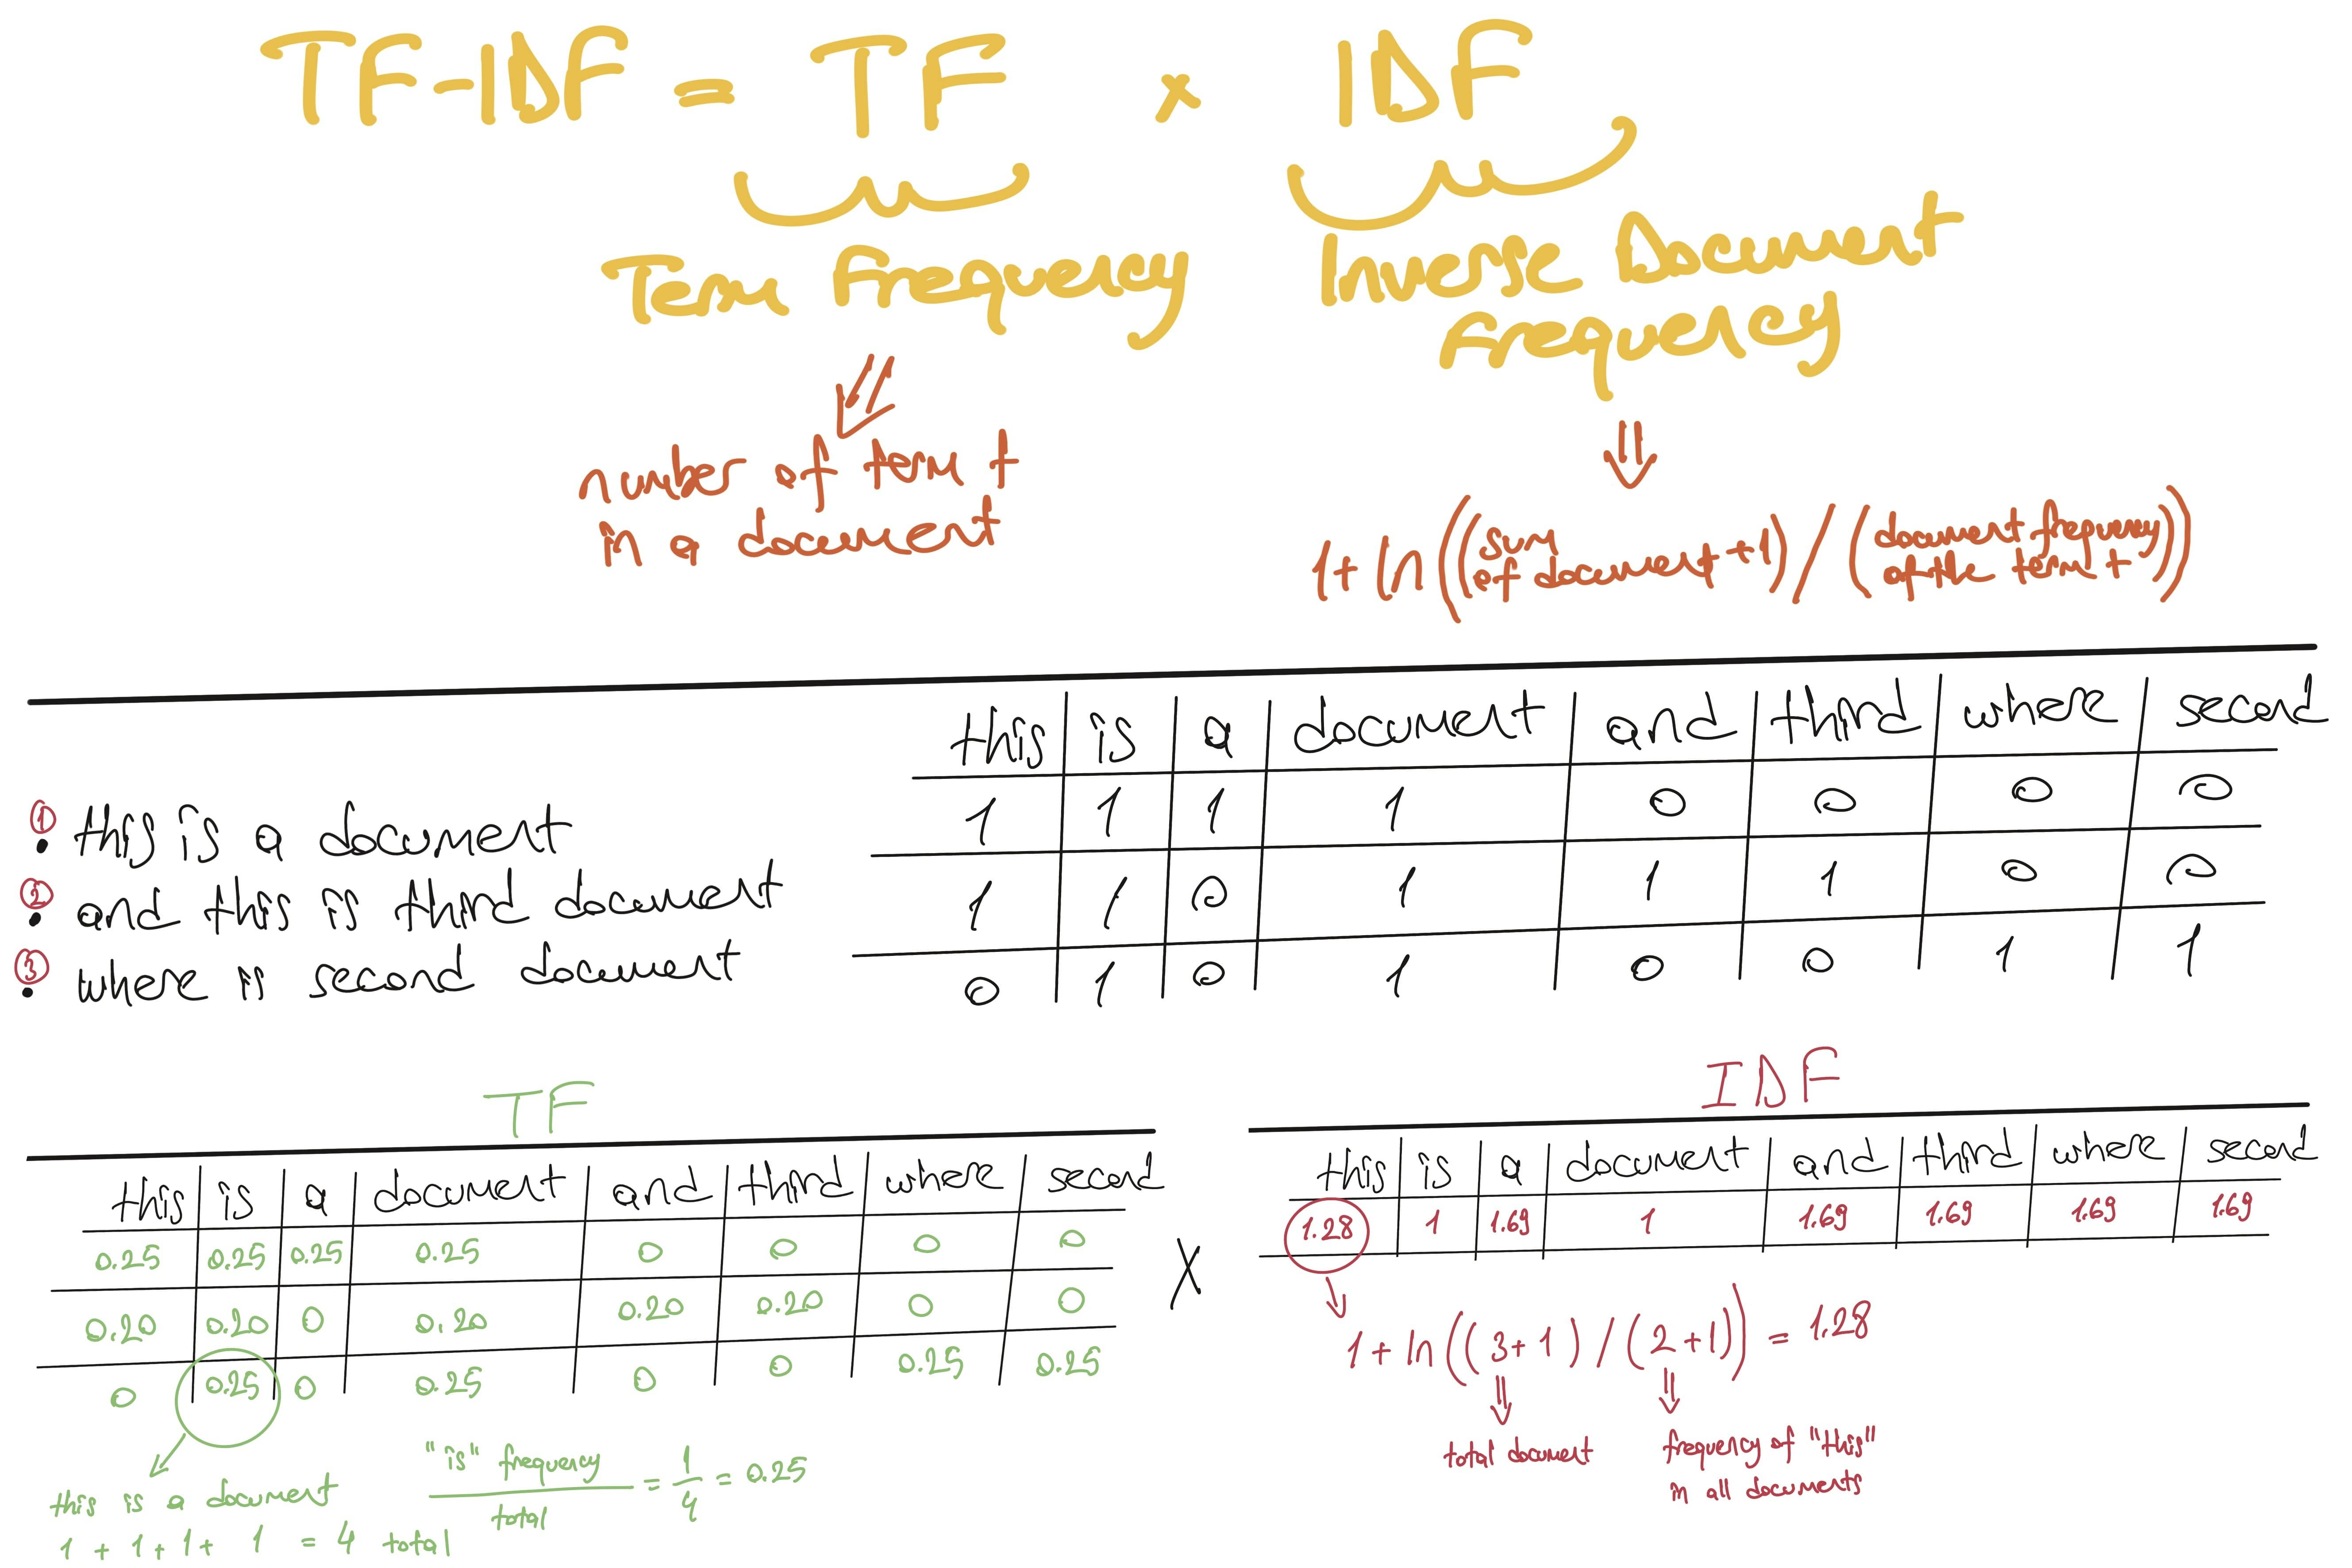

In [12]:
# We describe our feature and target.
y = df["sentiment_label"]  #target
X = df["text"]

# CountVectorizer returns unigrams or single words.
# If we increase the ngram_range, the vocabulary is expanded from single words to short phrases. 

# word vectorize (checking one word)
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

# n_gram vectorize (checking double words - phrases)
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

<hr style="height:2px;border-width:0;color:white;background-color:green">

# Sentiment Modelling

In [13]:
# Logistic Regression

# word
log_model_word = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model_word,
               X_tf_idf_word,
               y,
               scoring="accuracy",
               cv=5).mean()

0.7448717948717949

In [14]:
# Logistic Regression

# ngram
log_model_ngram = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model_ngram,
               X_tf_idf_ngram,
               y,
               scoring="accuracy",
               cv=5).mean()

0.6974358974358974

In [15]:
# Let's pick up a random tweet.

random_tweet = pd.Series(df["text"].sample(1).values)
random_tweet[0]

' officialtravlad crypto giveaway end hour x winner enter retweet follow offic'

In [16]:
# Example
# random tweet analysis

random_tweet = TfidfVectorizer().fit(X).transform(random_tweet)

# with Logistic Regression by word vectorize we found better score that's why we use for a predict log_model_word..

log_model_word.predict(random_tweet)

array([1])